# KPI 1 - Grid-to-Finish Delta - EDA and Hypothesis Testing

Load dataset used in notebook 1.2 into 1.3

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, mannwhitneyu, pearsonr

%matplotlib inline

In [2]:
df = pd.read_csv("/Users/frankdong/Documents/Analytics Local/williams-racing-strategies/processed_data/delta-all-circuits.csv")

In [3]:
df.head()

,Unnamed: 0,race_id,gp_year,gp_name,gp_round,driver_name,constructor,constructor_ref,is_williams,start_position,final_position,grid_delta,gained_or_lost,num_places
0,0,1029,2019,Brazilian Grand Prix,20,George Russell,Williams,williams,True,18,12,6,gained,6
1,1,1019,2019,British Grand Prix,10,George Russell,Williams,williams,True,19,14,5,gained,5
2,2,1023,2019,Italian Grand Prix,14,George Russell,Williams,williams,True,14,14,0,gained,0
3,3,1015,2019,Monaco Grand Prix,6,George Russell,Williams,williams,True,19,15,4,gained,4
4,4,1019,2019,British Grand Prix,10,Robert Kubica,Williams,williams,True,20,15,5,gained,5



EDA - let the data speak for itself through visualisations. 
Get to know the data both visually and statistically, lay the groundwork for analysis and hypothesis testing.
### 1. Start with core, rough visualisations. 
Histograms, boxplots, violin plots, scatterplots, barplots.  
### 2. Save all interesting "candidate" plots, output and save by exporting as PNG for review.
Plots may reveal surprising outliers, odd clusters, or clear trends
### 3. Annotate and document observations in Markdown
Write brief markdown notes next to each PNG. Note patterns, anomalies, large/small group sizes, etc.
### 4. Identify outliers, check sample sizes, assess normality. 
Key for hypothesis testing - boxplots and histograms help spot outliers and skew.
Check sample sizes with .groupby() or .value_counts() - are all groups (teams, circuits, years) large enough# for statistical tests?
### 5. Iterate and refine EDA
Select the most informative charts for polish, annotation, and inclusion in Tableau


## Steps 1, 2, 3. start with rough vizs, save interesting plots, and annotate observations

### 1: Pairplot

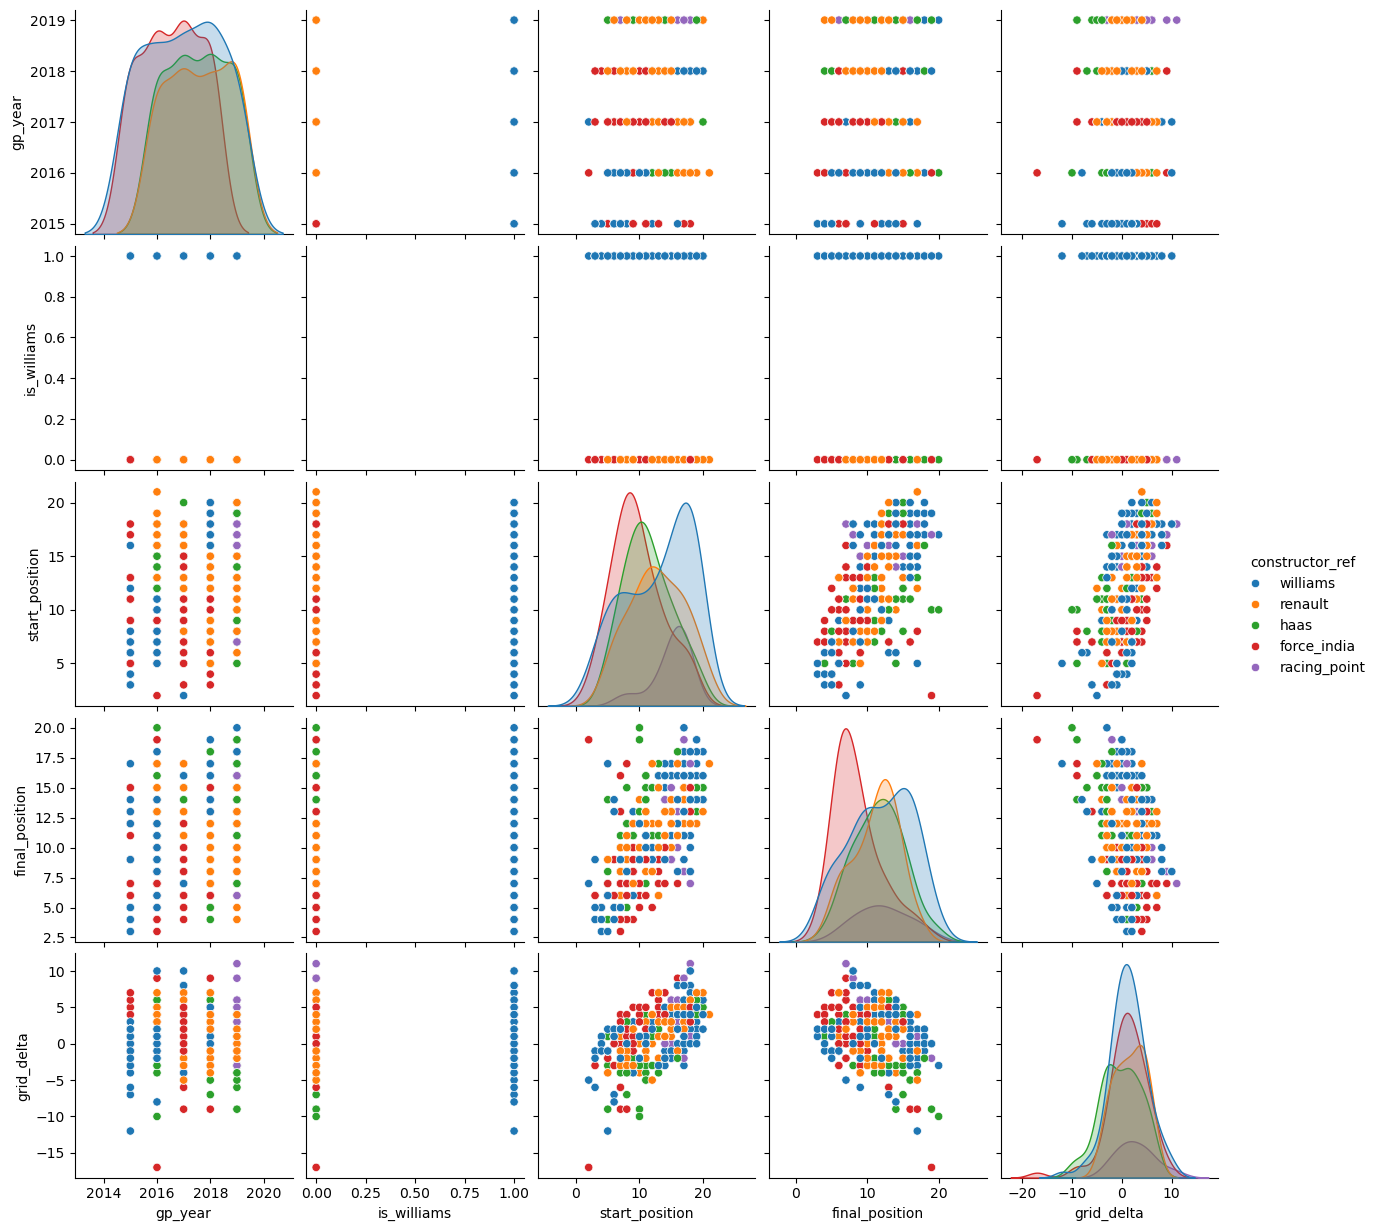

In [4]:
df_pairplot = df[['gp_year', 'gp_name', 'constructor_ref', 'is_williams', 'start_position', 'final_position', 'grid_delta']]
pairplot = sns.pairplot(df_pairplot, hue='constructor_ref') # pairplot automatically displayed

Pairplot isn't yielding great results. 
Probably better to focus on histograms, boxplots, barcharts - due to lack of continuous or spread out columns. 
Countplots and swarm/stripplots can also be useful for categorical relationships

### 2: Boxplot of grid delta by constructor

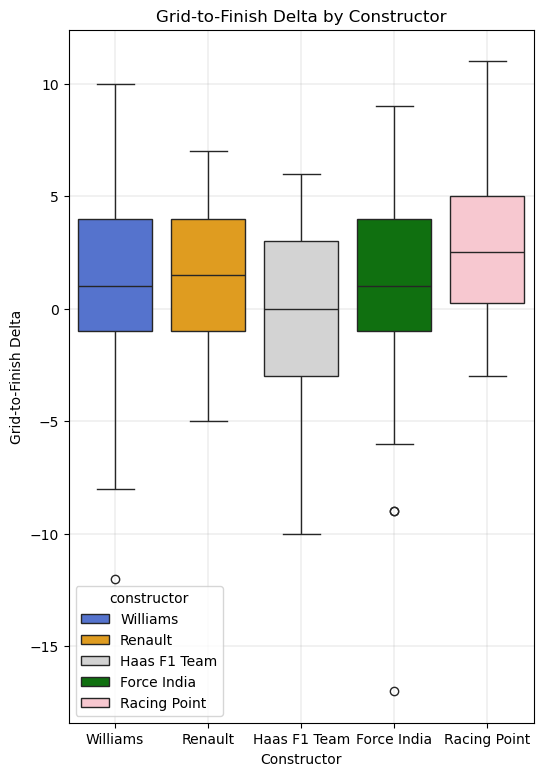

In [5]:
# setup a new figure and set its size - a taller boxplot helps us compare heights
plt.figure(figsize=(6, 9)) 

constructor_palette = {
    'Williams': 'royalblue', 
    'Renault': 'orange',
    'Haas F1 Team': 'lightgrey', 
    'Racing Point': 'pink', 
    'Force India': 'green'
}

# colour palette for the boxplot
constructor_boxplot = sns.boxplot( 
    x='constructor',
    y='grid_delta',
    data = df,
    hue = 'constructor',
    palette = constructor_palette, 
    legend = "brief"
)

constructor_boxplot.set_title('Grid-to-Finish Delta by Constructor')
constructor_boxplot.set_xlabel('Constructor')
constructor_boxplot.set_ylabel('Grid-to-Finish Delta')

plt.grid(linewidth = 0.25)
plt.show()

A boxplot is a way to show differences in how a set of numbers (like race position changes) are spread out and where most results tend to fall.


- The box shows where the middle half of the data set sits - so most results are in the box. (IQR)
- The line inside the box is the median - this tells us the typical "middle" value for the group. (50%)
- The "whiskers" are lines that extend out from the box - showcasing the range of most other results. (max/min)
- Circles beyond the whiskers are considered outliers, these are rare or unusually high/low results.


Williams has a slightly positive median and longer whiskers.
This means they typically gained positions, but the positions gained is highly variable compared to other teams. 

Renault has a similar profile to Williams, although with better position variability. 

Haas has the tallest box, meaning more variability in race position change. 

A median at 0 means they typically gain no positions, but a minimum (excl. outliers) of -10 means in their worst typical race, they could lose as many as 10 positions.

Force India, which later became Racing Point, demonstrate the improvement in race-day performance in both median positions gained, but also the potential to gain more positions (~11 positions for RP vs. ~9 for FI)
This showcases that RP improved on FI's foundation. 


### 3: Boxplot of williams grid delta vs. midfield rivals.

Create a label for clarity

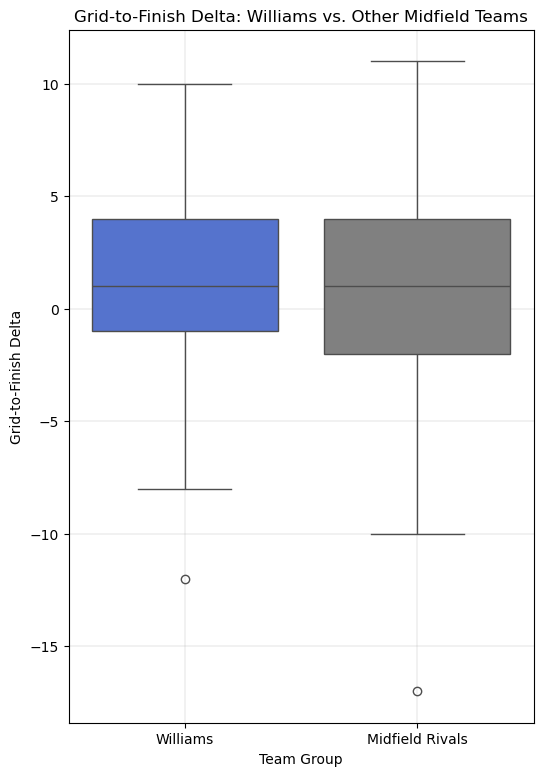

In [6]:
# set up a label for clarity
df['team_group'] = df['is_williams'].map({True: 'Williams', False: 'Midfield Rivals'})

# colour palette
group_palette = {
    'Williams': 'royalblue', 
    'Midfield Rivals': 'grey'
}

# new figure
plt.figure(figsize=(6, 9))
vs_rivals_boxplot = sns.boxplot(
    data = df,
    x = 'team_group',
    y = 'grid_delta',
    hue = 'team_group',
    palette = group_palette
) 

# editing the plot
vs_rivals_boxplot.set_title("Grid-to-Finish Delta: Williams vs. Other Midfield Teams")
vs_rivals_boxplot.set_xlabel("Team Group")
vs_rivals_boxplot.set_ylabel("Grid-to-Finish Delta")

plt.grid(linewidth = 0.25)
plt.show()

Williams' performance between 2015 and 2019 in race sessions is now compared to all midfield rivals together, Renault, Haas, Force India/Racing Point.

The collective 'Midfield Rivals' has a taller box, with 50% of values falling between +4 and -2, compared to that of Williams where the interquartile range falls between +4 and -1.

The whiskers of 'Midfield Rivals' are larger than Williams. This likely factors in the strong performances of Racing Point and the large losses of Haas in one visualisation - which results in significantly more breadth in results. 

By filtering for Williams vs. Midfield Rivals across different circuit types, we can get visual insights
that align closer with our target hypothesis - comparing Williams' performance to that of rivals across
high-downforce, technical circuits.  

### 4: Boxplot of williams' grid delta by circuit type. 

In [7]:
# label all the GPs by their manually-assigned circuit classification

circuit_type = {
	"Italian Grand Prix": "power",
	"Monaco Grand Prix": "technical",
	"British Grand Prix": "balanced",	
	"Belgian Grand Prix": "power",
	"Spanish Grand Prix": "balanced",
	"Singapore Grand Prix": "technical",
	"Brazilian Grand Prix": "power",
	"Hungarian Grand Prix": "technical",
	"Austrian Grand Prix": "power",
	"Japanese Grand Prix": "balanced"
}

df['circuit_type'] = df['gp_name'].map(circuit_type)

In a new sns.boxplot, filter df so that is_williams = True.

Create a new plot with x being circuit_type, y being grid-to-finish delta.

Plot will display williams' grid-to-finish delta across the three circuit types, 2015-2019.

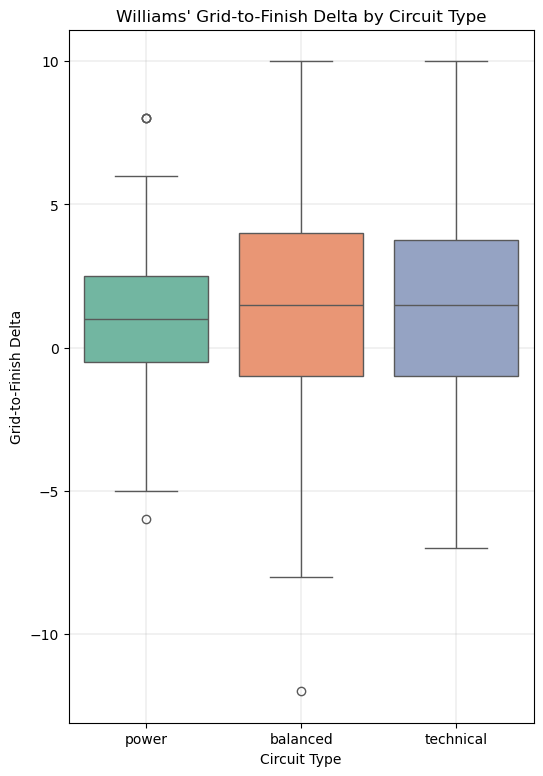

In [8]:
# setup a new figure and set its size - a taller boxplot helps us compare heights
plt.figure(figsize=(6, 9)) 

circuit_boxplot = sns.boxplot( 
    x='circuit_type',
    y='grid_delta',
    data = df[df['is_williams'] == True], # filter williams only results
    hue = 'circuit_type',
    palette = 'Set2'
)

# set titles and labels
circuit_boxplot.set_title("Williams' Grid-to-Finish Delta by Circuit Type")
circuit_boxplot.set_xlabel('Circuit Type')
circuit_boxplot.set_ylabel('Grid-to-Finish Delta')

plt.grid(linewidth = 0.25)
plt.show()

**Power Circuits**

Williams typically gained +2 places during races held at power tracks, (e.g. Monza and Spa)

The "box" is tight, meaning results were consistent, and most races fell close to that typical outcome. 

Although there were two exceptional races, e.g. one big gain of +8 places and a big loss of -6,  results tended towards a narrow range showing Williams can count on steady performance at circuits prioritising straight-line speed.


**Technical Circuits**

Results at technical tracks, like Monaco and Singapore, were more unpredictable. 

The box is taller, reflecting greater day-to-day swings. Williams sometimes made big gains of +10 places, but could alos loses as many as -7 places. 

The wider whiskers show that these races were less predictable - sometimes going very well, sometimes very badly. 

**Balanced Circuits**

Surprisingly, Williams saw even more ups and downs on balanced circuits, requiring a strong car both in the engine and chassis.

Here, botht he box and the whiskers are the largest - suggesting the team struggled to find the right mix,
or that small changes in setup or race events led to bigger swings in outcome.

These circuits produced both big wins, and big losses, and highlight where Williams' challenge in combining 
strengths were most exposed. 

### 5: Histograms to check for normality - for Williams

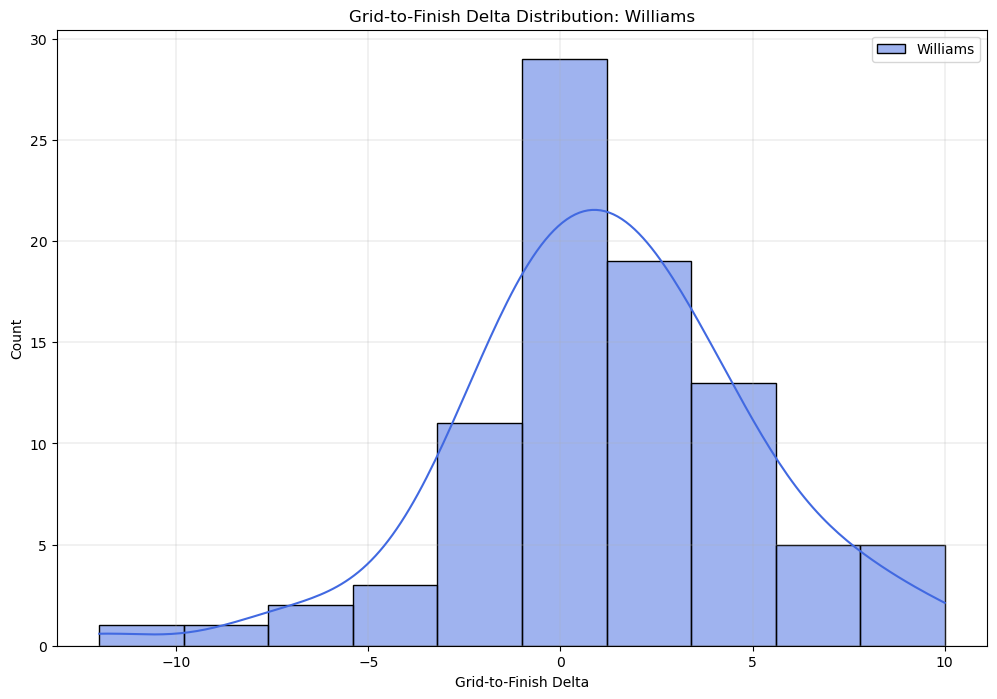

In [9]:
plt.figure(figsize=(12,8)) # set up a new figure

williams_delta_distribution = sns.histplot(
    data = df[df['constructor']=="Williams"]['grid_delta'], 
    kde = True, 
    stat = "count", 
    color = "royalblue", 
    label = "Williams", 
    alpha = 0.5
)

williams_delta_distribution.legend() # add a legend
williams_delta_distribution.set_title("Grid-to-Finish Delta Distribution: Williams")
williams_delta_distribution.set_xlabel("Grid-to-Finish Delta")
williams_delta_distribution.set_ylabel("Count")

plt.grid(linewidth = 0.25) # add slight gridlines
plt.show()

**General Observations:**

A histogram is used to count the number of occurences when a grid-to-finish delta falls into an appropriate range or "bin". This helps us see how Williams' race-day gains or losses are distributed.

The histogram (and KDE) is centered just right of zero, indicating that Williams drivers often gain positions on race day, but the distribution is moderately spread out. 

The shape appears approximately bell-shaped, and somewhat normal. However, it is not perfectly symmetrical.

It is visibly right-skewed, with a longer left tail towards negative values, displaying larger position losses.

The bulk of Williams' results are slight gains or small losses, with a gradual taper as you move outwards. 

**Hypothesis:** 

The earlier outlier of -12, from the boxplot, shows up as a very slight 'blip' far to the left of the main peak.

As it is rare, it doesn't distort the main shape, but does expand the full range of observed outcomes. 


**Impact on Hypothesis Testing:**

Most parametric tests (e.g. t-test for mean) assume the data has no major outliers, and is roughly normal.

A big negative outlier can inflate the calculated standard error and make it harder to achieve
statistical significance, esp. with a small group size. 

Flag the  outlier, then running the hypothesis test with and without it. 

Report both mean and median results, and maybe use non-parametric tests (like Mann-Whitney U) Shapiro-Wilk Test also helps confirm normality if sample size < 5,000.

if data remains non-normal with the outlier included. 

### 6: Histograms to check for normality - for rival constructors

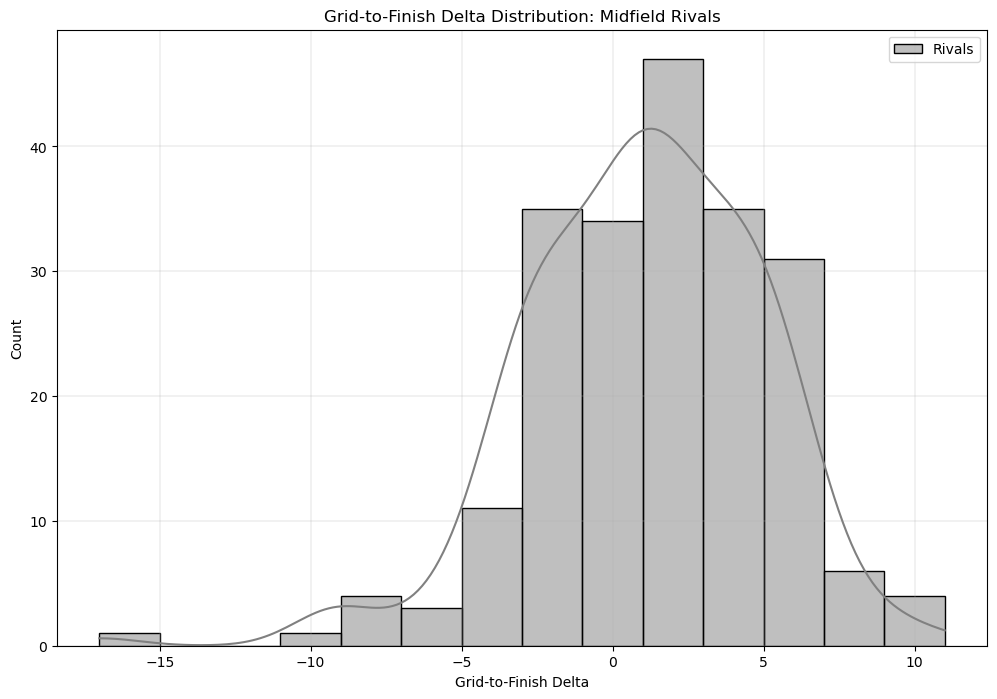

In [10]:
plt.figure(figsize=(12,8)) # set up a new figure

rivals_delta_distribution = sns.histplot(
    data = df[df['constructor']!="Williams"]['grid_delta'], 
    kde = True, 
    stat = "count", 
    color = "grey", 
    label = "Rivals", 
    alpha = 0.5
)

rivals_delta_distribution.legend() # add a legend
rivals_delta_distribution.set_title("Grid-to-Finish Delta Distribution: Midfield Rivals")
rivals_delta_distribution.set_xlabel("Grid-to-Finish Delta")
rivals_delta_distribution.set_ylabel("Count")

plt.grid(linewidth = 0.25) # add slight gridlines
plt.show()

### 7: Boxplots comparing team groups across circuit types 

#### 7.1: Boxplots comparing Williams and rivals across all circuit types

In [11]:
# team groups at df['team_group'] circuit types at df['circuit_type']
df[['gp_name', 'team_group', 'circuit_type', 'grid_delta']].head()

,gp_name,team_group,circuit_type,grid_delta
0,Brazilian Grand Prix,Williams,power,6
1,British Grand Prix,Williams,balanced,5
2,Italian Grand Prix,Williams,power,0
3,Monaco Grand Prix,Williams,technical,4
4,British Grand Prix,Williams,balanced,5


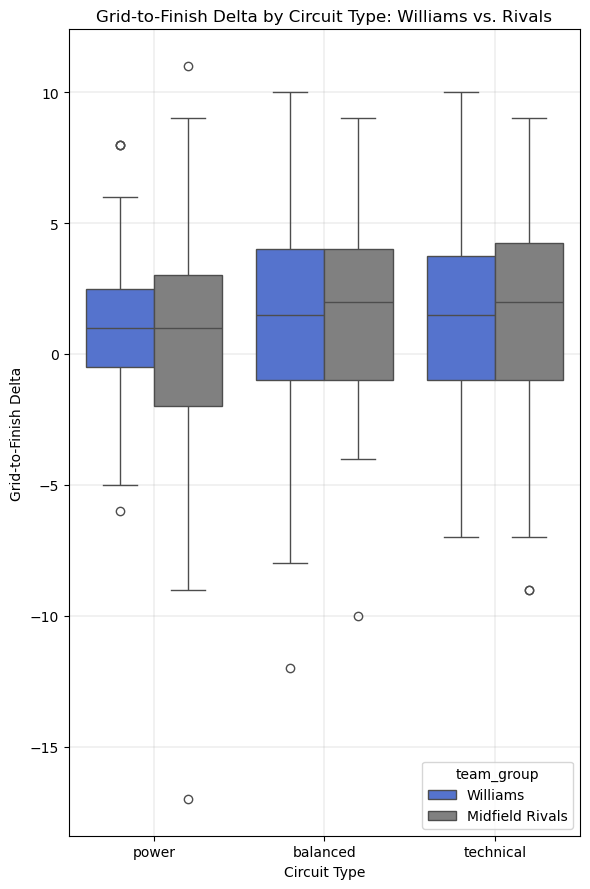

In [12]:
plt.figure(figsize = (6, 9))

vs_rivals_circuits = sns.boxplot(
    data = df,
    x = 'circuit_type', 
    y = 'grid_delta', 
    hue = 'team_group',
    palette = group_palette
)

vs_rivals_circuits.set_title("Grid-to-Finish Delta by Circuit Type: Williams vs. Rivals")
vs_rivals_circuits.set_xlabel("Circuit Type")
vs_rivals_circuits.set_ylabel("Grid-to-Finish Delta")

vs_rivals_circuits.grid(linewidth = 0.25)
plt.tight_layout()
plt.show()

Surprisingly, Williams showcases great consistency compared to all midfield rivals in power circuits, with an IQR between 2.5 and -0.5 places, compared to +3 and -2 of rivals.

It may also win +8 positions on circuits where straight-line speed is key. This contrasts with the more volatile results of its rivals, where outlier gains of +11 are possible, but also huge losses in position like -17 places.

Williams matches the IQR result of its rivals across balanced sectors, although its rivals typically gain +2 places compared to the +1.5 of Williams. 

Williams' whiskers are also larger compared to its rivals, with a max of +10 and a min of -8, demonstrating some volatility in results on balanced tracks. 

Surprisingly, Williams is more consistent on technical circuits - with its IQR falling between +3.5 and -1.

Midfield Rivals typically gain more places with a higher median and a upper quartile of +4.25, 
however its lowest loss, excluding one outlier, matches that of Williams at -7 places lost.

#### 7.2: Boxplots comparing Williams and rivals across technical circuits only 

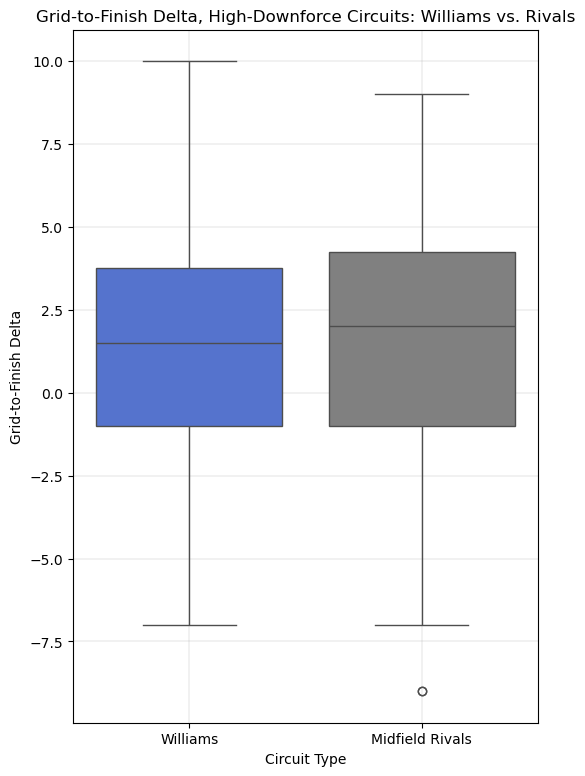

In [13]:
# filter the dataframe to include only technical circuits
df_technical = df[df['circuit_type'] == 'technical']

plt.figure(figsize = (6, 9))

vs_rivals_technical = sns.boxplot(
    data = df_technical,
    x = 'team_group', 
    y = 'grid_delta', 
    hue = 'team_group',
    palette = group_palette
)

vs_rivals_technical.set_title("Grid-to-Finish Delta, High-Downforce Circuits: Williams vs. Rivals")
vs_rivals_technical.set_xlabel("Circuit Type")
vs_rivals_technical.set_ylabel("Grid-to-Finish Delta")

plt.grid(linewidth = 0.25)

plt.show()

Williams is more consistent on technical circuits compared to its balanced circuit performance.

Its IQR, or middle 50% of values, falls between +3.5 and -1 places. 

Midfield rivals typically gain more places with a higher median and a upper quartile of +4.25, however its lowest loss, excluding one outlier of -9 places, matches that of Williams at -7 places lost.

Visually, it seems that the null hypothesis is likely to be accepted. 

No outliers also exist in the Williams box-and-whisker section, allowing us to conduct hypothesis testing with ease. 

#### 8: Normality check of Williams and technical circuits

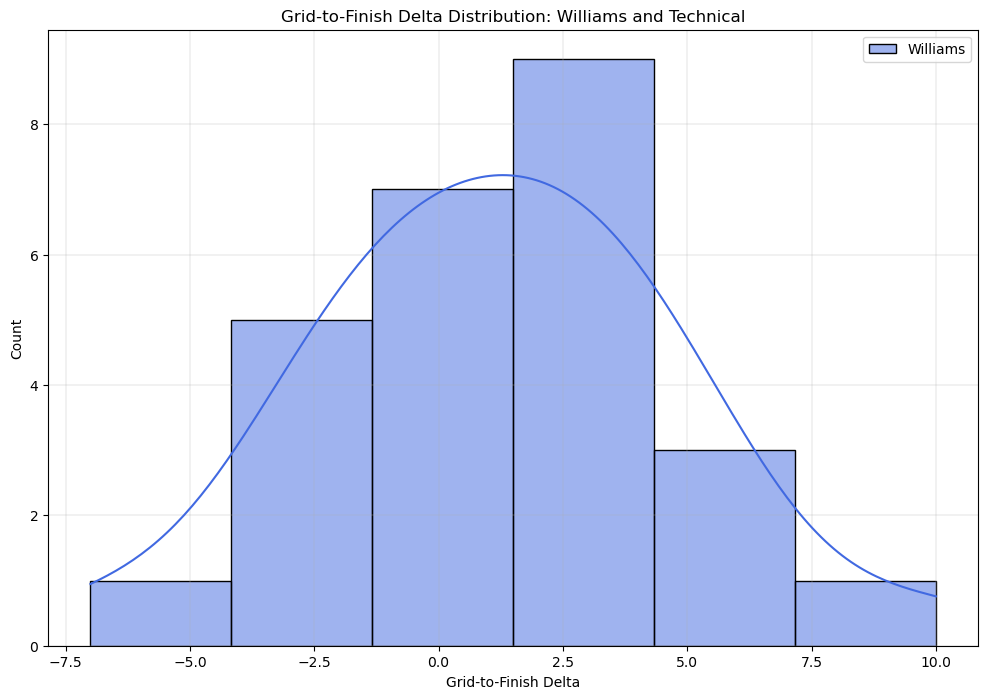

In [14]:
plt.figure(figsize=(12,8)) # set up a new figure

williams_delta_distribution_technical = sns.histplot(
    data = df_technical[df_technical['constructor']=="Williams"]['grid_delta'], 
    kde = True, 
    stat = "count", 
    color = "royalblue", 
    label = "Williams", 
    alpha = 0.5
)

williams_delta_distribution_technical.legend() # add a legend
williams_delta_distribution_technical.set_title("Grid-to-Finish Delta Distribution: Williams and Technical")
williams_delta_distribution_technical.set_xlabel("Grid-to-Finish Delta")
williams_delta_distribution_technical.set_ylabel("Count")

plt.grid(linewidth = 0.25) # add slight gridlines
plt.show()

KDE is fairly bell-curve shaped, with a clear mode and no outliers. 
However, small sample size < 30 will be an issue during hypothesis testing. 

#### 9: Normality check of Williams and technical circuits

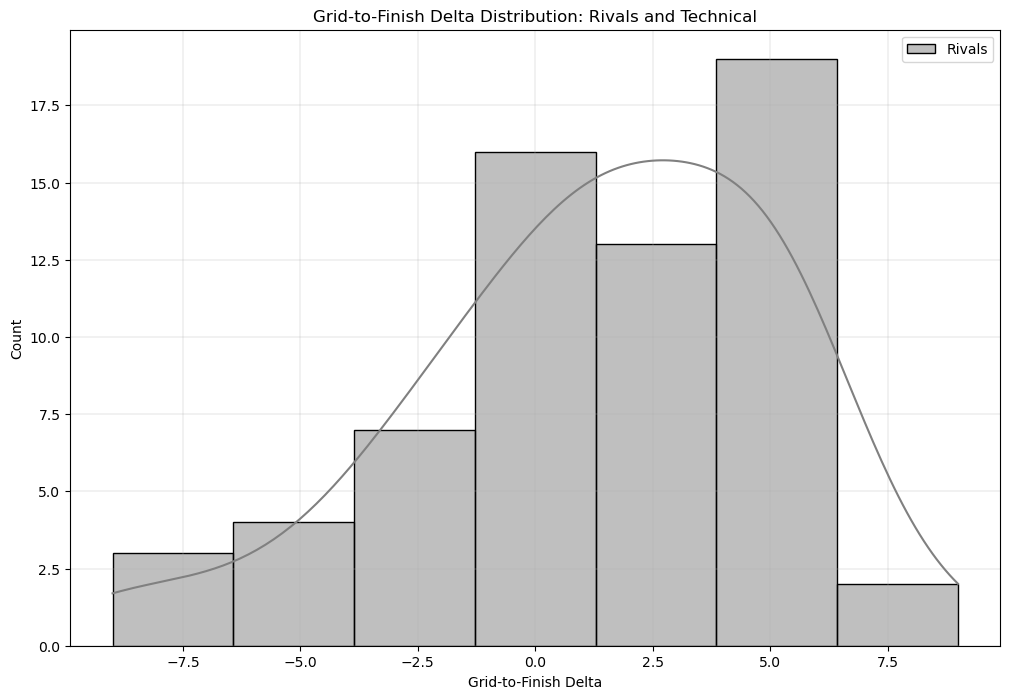

In [15]:
plt.figure(figsize=(12,8)) # set up a new figure

rivals_delta_distribution_technical = sns.histplot(
    data = df_technical[df_technical['constructor']!="Williams"]['grid_delta'], 
    kde = True, 
    stat = "count", 
    color = "grey", 
    label = "Rivals", 
    alpha = 0.5
)

rivals_delta_distribution_technical.legend() # add a legend
rivals_delta_distribution_technical.set_title("Grid-to-Finish Delta Distribution: Rivals and Technical")
rivals_delta_distribution_technical.set_xlabel("Grid-to-Finish Delta")
rivals_delta_distribution_technical.set_ylabel("Count")

plt.grid(linewidth = 0.25) # add slight gridlines
plt.show()



KDE is bimodal and right-skewed. Not being normally distributed might affect our hypothesis testing.
An outlier results in a left tail in the distribution. 
However, n > 30. 


## Step 4. Perform hypothesis testing 

First, we need to count samples for each group at technical circuits

In [16]:
sample_counts = df_technical['team_group'].value_counts()
print("Sample sizes at technical circuits: \n", sample_counts)

Sample sizes at technical circuits: 
 team_group
Midfield Rivals    64
Williams           26
Name: count, dtype: int64


Sample sizes at technical circuits:
Midfield Rivals    64
Williams           26

For Williams, n < 30, but for Midfield Rivals, n > 30. 

However, Williams is unimodal and normal, but Midfield Rivals is bimodal and has a distribution that is skewed-right.

We will perform a standard Welch's t-test (despite midfield rivals being not normally distributed), followed by a Mann-Whitney U test (non-parametric alternative to t-test), make observations, noting differences from both (as one is parametric and one is non-parametric) and compare results - at a 95% confidence level.




Hypothesis Recap: 
Comparing "Williams' mean grid-to-finish position delta vs. that of midfield rivals, on technical circuits."
Groups: 
- Williams: n = 26
- Midfield Rivals: n = 64
- Two different populations - Williams vs. not-Williams.
- We are testing if Williams is significantly worse, not just different, so we also care about direction.
We are performing a two-sample, independent, one-tailed Welch's t-test, testing if Williams' mean grid delta
is significantly worse (lower) than midfield rivals on technical circuits. 
H0 (Null): μ_Williams ≥ μ_Rivals
H1 (Alt): μ_Williams < μ_Rivals


### 1. Extract relevant data for the test

In [17]:
williams_deltas = df_technical[df_technical['constructor']=="Williams"]['grid_delta']
rival_deltas = df_technical[df_technical['constructor']!="Williams"]['grid_delta']

### 2. Run the Welch's one-tailed t-test

In [18]:
t_stat, p_value = ttest_ind(
    williams_deltas,
    rival_deltas, 
    equal_var = False,
    alternative = 'less' # defines the alternative hypothesis
)

In [19]:
print("\nWelch's t-test for Williams vs. Rivals on technical circuits at 95% confidence interval.\n")
print(f"t-statistic: {t_stat:.3f}")
print(f"One-tailed p-value: {p_value:.4f}")


Welch's t-test for Williams vs. Rivals on technical circuits at 95% confidence interval.

t-statistic: -0.157
One-tailed p-value: 0.4381


In [20]:
alpha = 0.05  # 95% confidence level
if p_value < alpha:
    print("\nReject the null hypothesis (H1): Williams' mean grid-to-finish delta IS significantly worse than rivals on technical circuits.")
else: # p_value_one_tailed >= alpha
    print("\nFail to reject the null (H0): No significant evidence that Williams' mean grid-to-finish delta is worse than rivals on technical circuits.")


Fail to reject the null (H0): No significant evidence that Williams' mean grid-to-finish delta is worse than rivals on technical circuits.


Result: fail to reject H0. 

t-stat: -0.157

one-tailed p-value: 0.4381 (> 0.05)

However, the p-value could be skewed as the rival distribution isn't normal. We will now perform a non-parametric Mann-Whitney U test. 


### 3. Run the Mann-Whitney U Test

In [21]:
m_stat, p_value = mannwhitneyu(williams_deltas, rival_deltas, alternative="less")

In [22]:
print("\nMann-Whitney U Test for Williams vs. Rivals on technical circuits at 95% confidence interval.\n")
print(f"Mann-Whitney U statistic: {m_stat:.3f}")
print(f"One-tailed p-value: {p_value:.4f}")


Mann-Whitney U Test for Williams vs. Rivals on technical circuits at 95% confidence interval.

Mann-Whitney U statistic: 777.000
One-tailed p-value: 0.3131


In [23]:
if p_value < alpha:
    print("\nReject the null hypothesis (H1): Williams' mean grid-to-finish delta IS significantly worse than rivals on technical circuits.")
else: # p_value_one_tailed >= alpha
    print("\nFail to reject the null (H0): No significant evidence that Williams' mean grid-to-finish delta is worse than rivals on technical circuits.")


Fail to reject the null (H0): No significant evidence that Williams' mean grid-to-finish delta is worse than rivals on technical circuits.


Result: fail to reject H0. 

Mann-Whitney U statistic: 777.000

One-tailed p-value: 0.3131

Even under a non-parametric test, which provides a robust way of testing the hypothesis
despite a skewed rival distribution and n < 30 for Williams, we fail to reject the null hypothesis. 

Results will be similar, if we exclude the outlier value in the rival data.

### 4. Repeat, but label and remove the outlier of ~(-9) in the rival deltas data. 

In [24]:
outlier_value = rival_deltas.min()  # find the outlier value
rival_deltas_no_outlier = rival_deltas[rival_deltas > outlier_value]

We'll perform a quick distribution check, after removing the outlier, before performing the second Mann-Whitney U test.

In [25]:
plt.figure(figsize=(12,8)) # set up a new figure

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

Plot a histogram for rivals, technical - check for normality with rival_deltas_no_outlier.

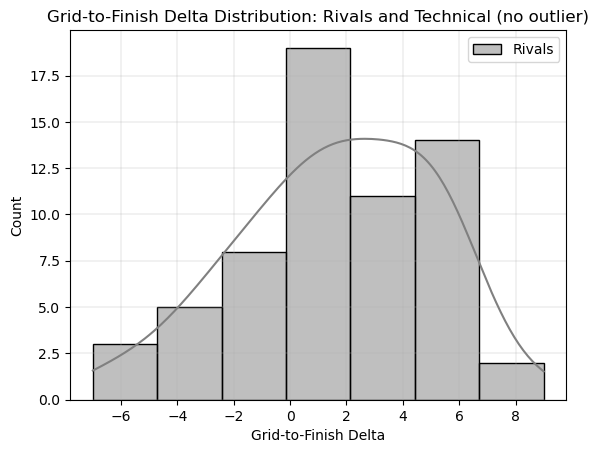

In [26]:
rivals_delta_distribution_technical_no_outlier = sns.histplot(
    data = rival_deltas_no_outlier,
    kde = True, 
    stat = "count", 
    color = "grey", 
    label = "Rivals", 
    alpha = 0.5
)

rivals_delta_distribution_technical_no_outlier.legend() # add a legend
rivals_delta_distribution_technical_no_outlier.set_title("Grid-to-Finish Delta Distribution: Rivals and Technical (no outlier)")
rivals_delta_distribution_technical_no_outlier.set_xlabel("Grid-to-Finish Delta")
rivals_delta_distribution_technical_no_outlier.set_ylabel("Count")

plt.grid(linewidth = 0.25) # add slight gridlines
plt.show()

KDE still bimodal and right-skewed, but not as sharply. 
Not being normally distributed might still affect our hypothesis testing.
An outlier results in a left tail in the distribution. 
However, n > 30.

In [27]:
t_stat_filtered, p_value_filtered = ttest_ind(
    williams_deltas,
    rival_deltas_no_outlier, 
    equal_var = False,
    alternative = 'less' # defines the alternative hypothesis
)

Welch's t-test, no outliers. 

In [28]:
p_value_one_tailed_filtered = p_value_filtered / 2 # for one tail, the left side of the bell curve

In [29]:
print("\n\nWelch's t-test for Williams vs. Rivals on technical circuits at 95% confidence level (no outlier).\n")
print(f"t-statistic: {t_stat_filtered:.3f}")
print(f"One-tailed p-value: {p_value_filtered:.4f}")



Welch's t-test for Williams vs. Rivals on technical circuits at 95% confidence level (no outlier).

t-statistic: -0.556
One-tailed p-value: 0.2904


In [30]:
alpha = 0.05  # 95% confidence level
if p_value_filtered < alpha:
    print("\nReject the null hypothesis (H1): Williams' mean grid-to-finish delta IS significantly worse than rivals on technical circuits.")
else: # p_value_one_tailed >= alpha
    print("\nFail to reject the null (H0): No significant evidence that Williams' mean grid-to-finish delta is worse than rivals on technical circuits.")


Fail to reject the null (H0): No significant evidence that Williams' mean grid-to-finish delta is worse than rivals on technical circuits.


Mann-Whitney U test, no outliers 

In [31]:
m_stat_filtered, p_value_filtered_2 = mannwhitneyu(williams_deltas, rival_deltas_no_outlier, alternative="less")

In [32]:
print("\nMann-Whitney U Test for Williams vs. Rivals on technical circuits at 95% confidence level (no outlier).\n")
print(f"Mann-Whitney U statistic: {m_stat_filtered:.3f}")
print(f"One-tailed p-value: {p_value_filtered_2:.4f}")


Mann-Whitney U Test for Williams vs. Rivals on technical circuits at 95% confidence level (no outlier).

Mann-Whitney U statistic: 725.000
One-tailed p-value: 0.2299


In [33]:
if p_value_filtered_2 < alpha:
    print("\nReject the null hypothesis (H1): Williams' mean grid-to-finish delta IS significantly worse than rivals on technical circuits.")
else: # p_value_filtered_2 >= alpha
    print("\nFail to reject the null (H0): No significant evidence that Williams' mean grid-to-finish delta is worse than rivals on technical circuits.")


Fail to reject the null (H0): No significant evidence that Williams' mean grid-to-finish delta is worse than rivals on technical circuits.



**Welch's t-test for Williams vs. Rivals on technical circuits at 95% confidence level (no outlier).**

t-statistic: -0.556

One-tailed p-value: 0.1452

Fail to reject the null (H0): No significant evidence that Williams' mean grid-to-finish delta is worse than rivals on technical circuits.


**Mann-Whitney U Test for Williams vs. Rivals on technical circuits at 95% confidence level (no outlier).**

Mann-Whitney U statistic: 725.000

One-tailed p-value: 0.2299

Fail to reject the null (H0): No significant evidence that Williams' mean grid-to-finish delta is worse than rivals on technical circuits.


## Step 5: Create new plots 

#### 1. Stripplot - micro-level view of race deltas by constructor 

Emphasises individual race performances - helps us spot outliers and clusters. 

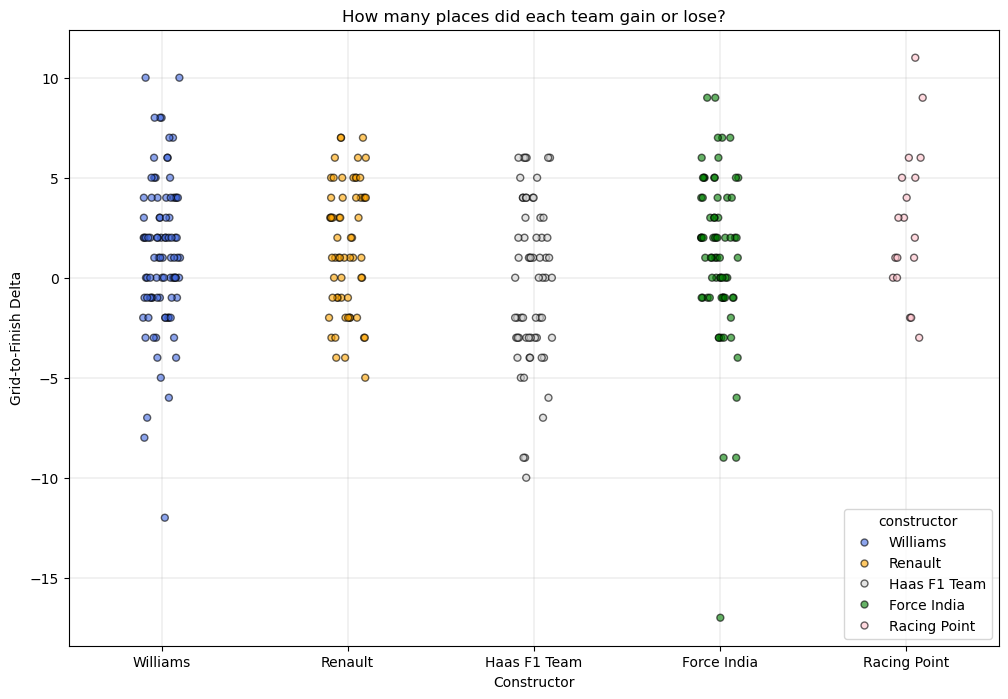

In [34]:
plt.figure(figsize = (12,8))
constructor_stripplot = sns.stripplot(
    data=df, 
    x="constructor", 
    y="grid_delta", 
    hue = "constructor",
    palette = constructor_palette,
    edgecolor = "black",
    linewidth = 1, # adds a border around each marker
    legend = "brief", # add a legend
    jitter=True, 
    alpha=0.6
)

constructor_stripplot.set_title("How many places did each team gain or lose?")
constructor_stripplot.set_xlabel("Constructor")
constructor_stripplot.set_ylabel("Grid-to-Finish Delta")

plt.grid(linewidth = 0.25)
plt.show()

#### 2. Barplot - mean grid delta by year. 

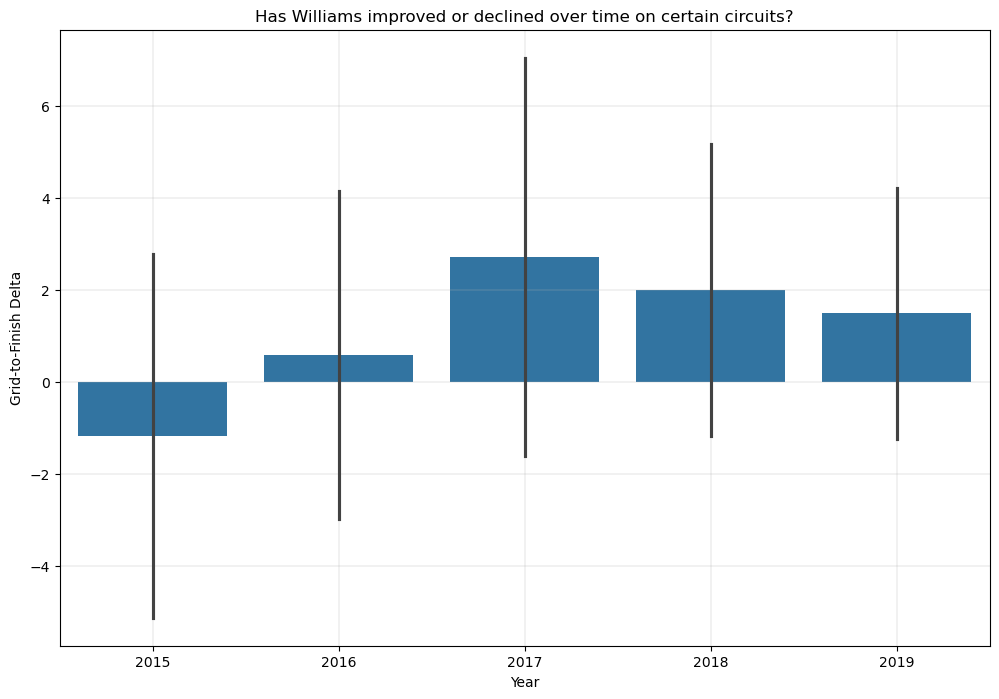

In [35]:
plt.figure(figsize = (12,8))

df_williams = df[df['is_williams'] == True]

williams_barplot = sns.barplot(
    data=df_williams, 
    x="gp_year", 
    y="grid_delta", 
    errorbar = 'sd'
)

williams_barplot.set_title("Has Williams improved or declined over time on certain circuits?")
williams_barplot.set_xlabel("Year")
williams_barplot.set_ylabel("Grid-to-Finish Delta")

plt.grid(linewidth = 0.25)
plt.show()

The way positive and negative results are possible, and the long lines, make this plot really ineffective.  

#### 3. Lineplot of Williams' race performance trend also combining Williams' performance across the three circuit types. 

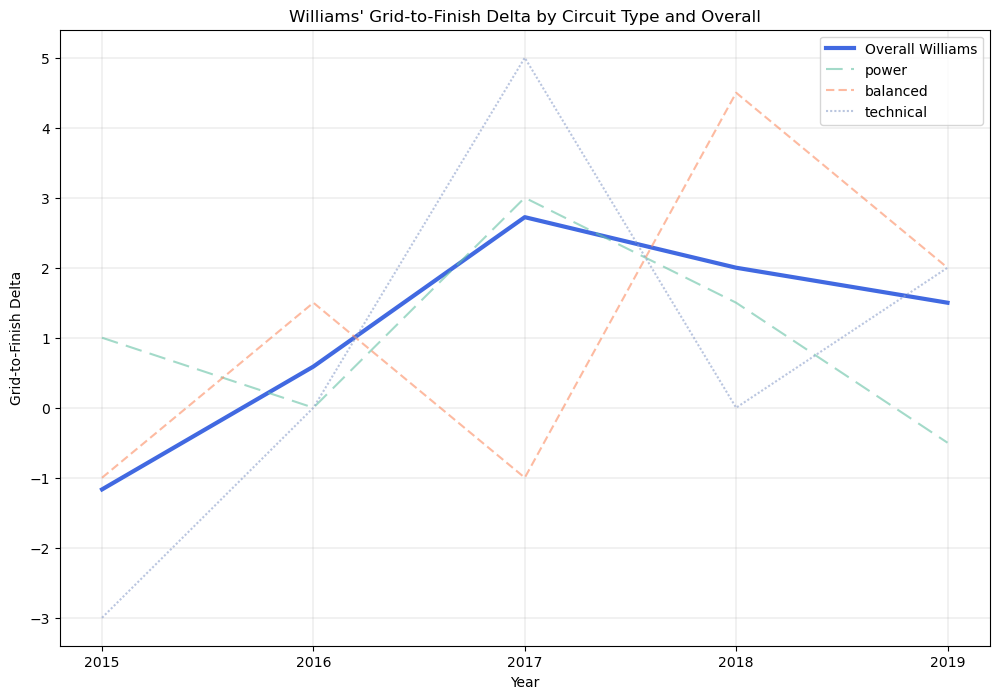

In [36]:
plt.figure(figsize = (12,8))

# calculate overall Williams performance across years:
overall = df_williams.groupby("gp_year")["grid_delta"].mean().reset_index()

# plot overall Williams performance in royalblue colour, and a slightly thicker line
sns.lineplot(
    data=overall, 
    x="gp_year", 
    y="grid_delta", 
    color="royalblue", 
    label="Overall Williams", 
    errorbar = None, # no confidence interval
    linewidth = 3 # slightly thicker line
)

# now plot Williams' performance per circuit type on top, using Set2 palette:
sns.lineplot(
    data=df_williams,
    x="gp_year",
    y="grid_delta",
    hue="circuit_type",
    palette='Set2',
    estimator='median',
    legend="full",
    errorbar=None,
    alpha=0.6,
    style="circuit_type",
    dashes= {
        'power': (8, 4), # long dashes
        'balanced': (4, 2), # medium dashes,
        'technical': (1,1), # very short dashes
    }
)
# median may be better as an estimator if outliers exist
# confidence interval is also removed for better visibility.

plt.title("Williams' Grid-to-Finish Delta by Circuit Type and Overall")
plt.xlabel("Year")
plt.xticks(np.arange(2015, 2020, 1)) # set the x-ticks so no fractional years occur
plt.ylabel("Grid-to-Finish Delta")

plt.grid(linewidth=0.25)
plt.legend()
plt.show()


#### 4. Violin plot of grid delta by constructor.

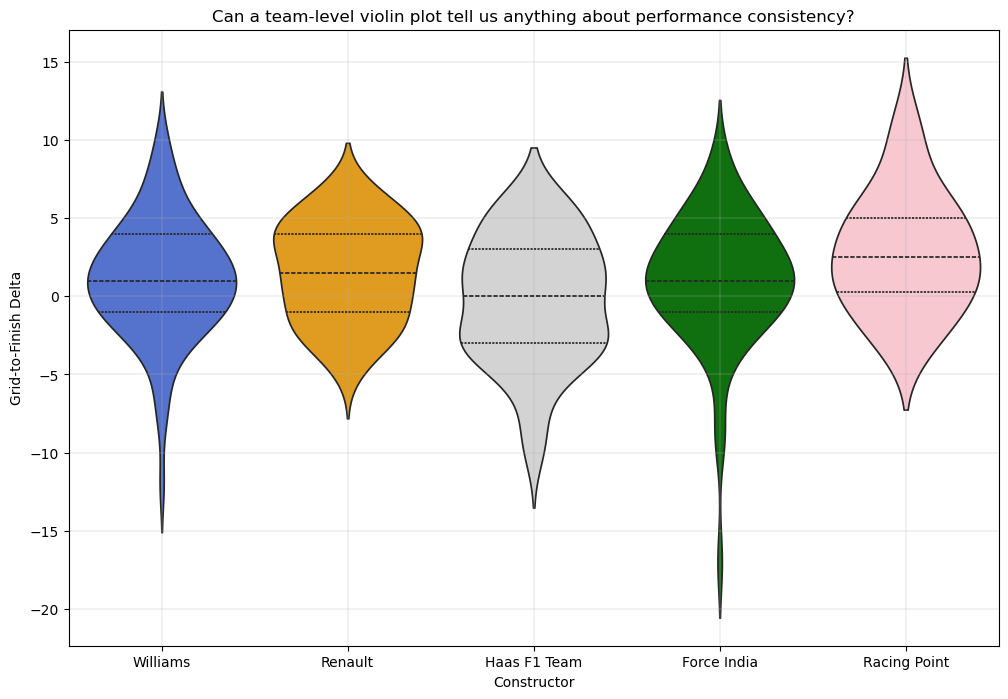

In [37]:
plt.figure(figsize = (12,8))
constructor_violinplot = sns.violinplot(
    data=df, 
    x="constructor", 
    y="grid_delta", 
    inner="quartile",
    hue = "constructor",
    palette = constructor_palette
)

constructor_violinplot.set_title("Can a team-level violin plot tell us anything about performance consistency?")
constructor_violinplot.set_xlabel("Constructor")
constructor_violinplot.set_ylabel("Grid-to-Finish Delta")

plt.grid(linewidth = 0.25)
plt.show()

#### 5. Facetgrid stripplot by year

/opt/anaconda3/lib/python3.12/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the stripplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


<Figure size 1200x800 with 0 Axes>

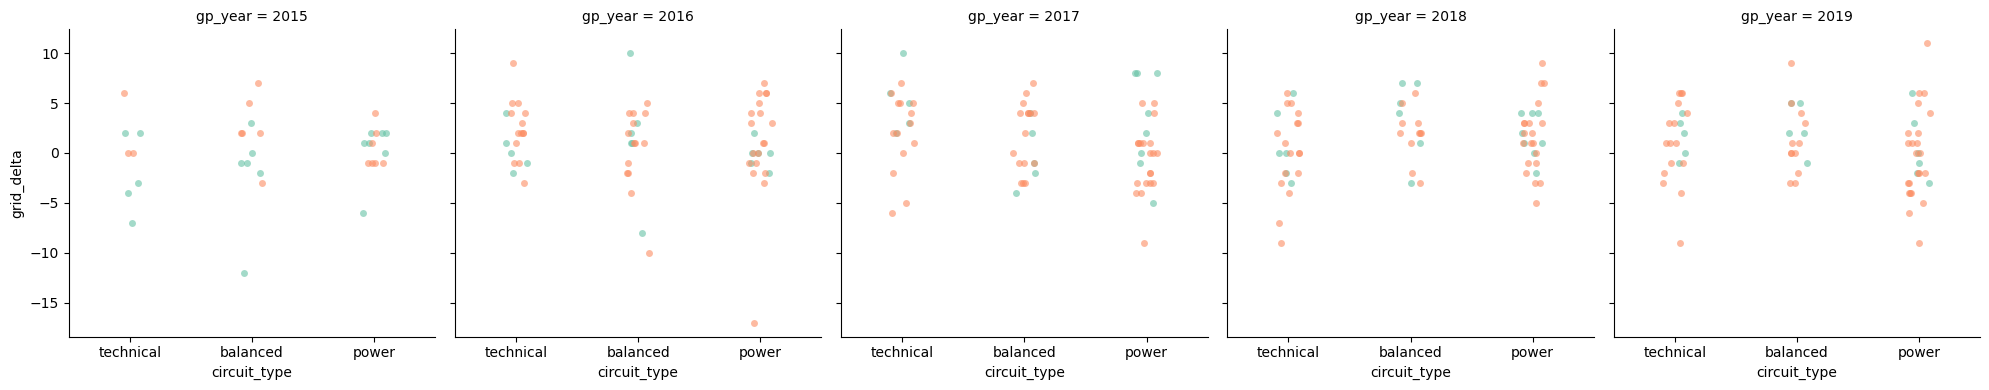

In [38]:
plt.figure(figsize = (12, 8))
grid = sns.FacetGrid(df, col="gp_year", hue="team_group", height=4, palette = "Set2") # set up facetgrid
grid.map(sns.stripplot, "circuit_type", "grid_delta", jitter=True, alpha=0.6)

#### 6. Heatmap of average position delta by constructor

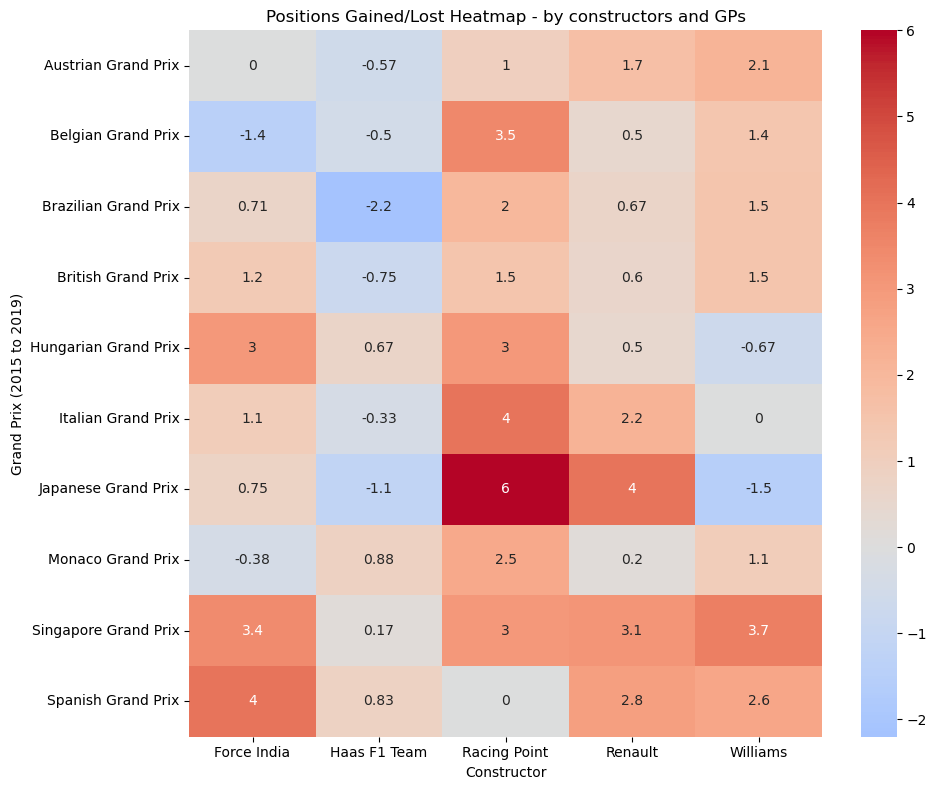

In [39]:
plt.figure(figsize = (10,8))

pivot = df.pivot_table(index="gp_name", columns="constructor", values="grid_delta", aggfunc="mean")
heatmap = sns.heatmap(pivot, annot=True, cmap="coolwarm", center=0)

heatmap.set_title("Positions Gained/Lost Heatmap - by constructors and GPs")
heatmap.set_xlabel("Constructor")
heatmap.set_ylabel("Grand Prix (2015 to 2019)")

plt.tight_layout()
plt.show()

#### 7. Regression plot - start position vs grid_delta for williams, observing and identifying relationships

([<matplotlib.axis.XTick at 0x14cc3eab0>,
 [Text(22, 0, '22'),
  Text(21, 0, '21'),
  Text(20, 0, '20'),
  Text(19, 0, '19'),
  Text(18, 0, '18'),
  Text(17, 0, '17'),
  Text(16, 0, '16'),
  Text(15, 0, '15'),
  Text(14, 0, '14'),
  Text(13, 0, '13'),
  Text(12, 0, '12'),
  Text(11, 0, '11'),
  Text(10, 0, '10'),
  Text(9, 0, '9'),
  Text(8, 0, '8'),
  Text(7, 0, '7'),
  Text(6, 0, '6'),
  Text(5, 0, '5'),
  Text(4, 0, '4'),
  Text(3, 0, '3'),
  Text(2, 0, '2'),
  Text(1, 0, '1')])

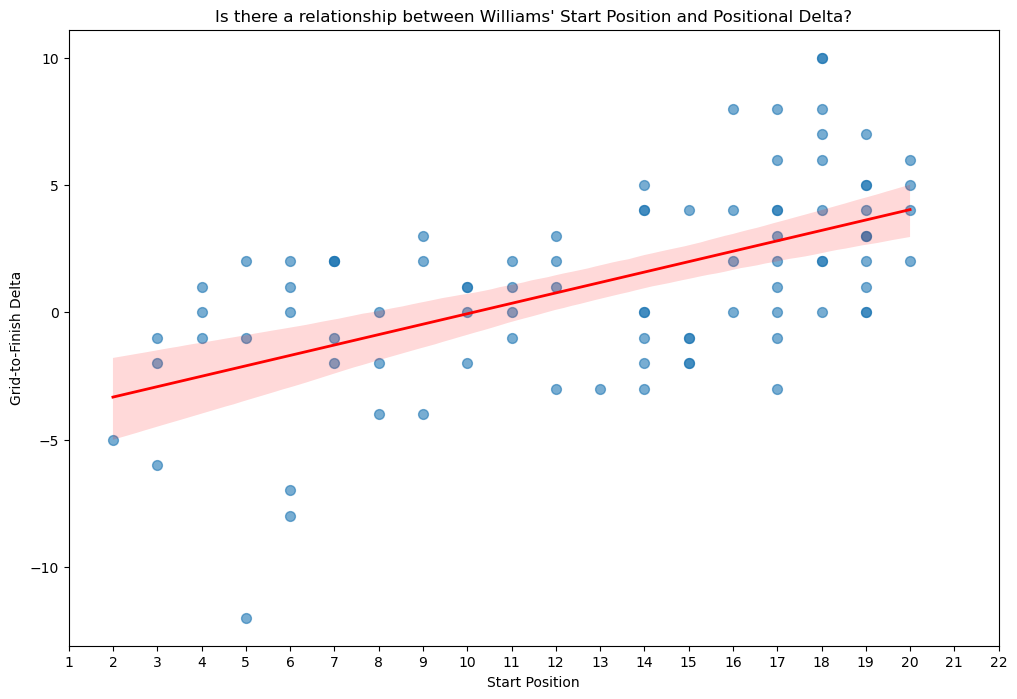

In [40]:
plt.figure(figsize=(12, 8))

williams_regplot = sns.regplot( # Fit a regression line to Williams' start position vs. grid delta
    data=df_williams,
    x="start_position",
    y="grid_delta",
    scatter=True,
    scatter_kws={"s": 50, "alpha": 0.6},  # adjust scatter marker size and transparency
    line_kws={"color": "red", "linewidth": 2},  # regression line style
    ci=95  # show confidence interval, can set to None to remove
)

williams_regplot.set_title("Is there a relationship between Williams' Start Position and Positional Delta?")
williams_regplot.set_xlabel("Start Position")
williams_regplot.set_ylabel("Grid-to-Finish Delta")

plt.xticks(np.arange(22, 0, -1)) # place x ticks in reverse order - 20th to 1st.

We can also get the correlation coefficient too - using scipy.stats.

In [41]:
# Filter just Williams data

williams_start = df_williams["start_position"]
williams_delta = df_williams["grid_delta"]

#Calculate Pearson correlation coefficient and p-value
r_value, p_value = pearsonr(williams_start, williams_delta)

print(f"\nPearson correlation coefficient (r): {r_value:.3f}")
print(f"P-value: {p_value:.4f}\n")


Pearson correlation coefficient (r): 0.573
P-value: 0.0000



Remember - r value range interpretation:

- 0.00 to ±0.19 -> Very weak / no correlation
- ±0.20 to ±0.39 -> Weak correlation
- ±0.40 to ±0.59 -> Moderate correlation
- ±0.60 to ±0.79 -> Strong correlation
- ±0.80 to ±1.00 -> Very strong correlation

A -r means: starting further back = more gain.

A +r means: better start = better result (less gain/loss needed).

A p-value < 0.05 indicates the correlation is statistically significant.


Pearson correlation coefficient (r): 0.573
P-value: 0.0000

Of interest: a positively moderate correlation of +0.573 can be seen. 

This means that a better start is linked with a better result. (less gain/loss needed)

The p-value is 0.0000 as well - to four decimal places. 

This is an extremely statistically significant result - essentially 0% chance the observed correlation is due to random chance. 
There is a statistically significant correlation between: 
- start_postiion, where the car starts
- and grid_delta, the positions gained/lost

This means - the postiion Williams starts has a strong relationship with how much they gain or lose duing the race - basically, common sense checks out mathematically

For stakeholders: 

> "There's a statistically significant correlation between start position and race performance, 
> but it's only moderate. This confirms that qualifying matters — but there's room for race-day factors 
> (e.g. strategy, weather, incidents) to play a big role too."
